In [18]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import Atlas, fast_hist, reshape_pvalues, vec_idx_to_mat_idx

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "schaeffer"
SOFT = False
pd.options.mode.copy_on_write = True
MACRO_LABELS = True

if MACRO_LABELS:
    from bold_dementia.connectivity import plot_matrix
else:
    from bold_dementia.connectivity import plot_ordered_matrix as plot_matrix # TODO This could be better

In [19]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}__strategy-high_pass-motion-wm_csf"
)
print(f"Fetching data in {matrices_path}")
# TODO Allow longitudinal and add subject_id to random effects
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer__strategy-high_pass-motion-wm_csf


In [20]:
def mat_to_vec(mat):
    n = len(mat)
    tril_i = np.tril_indices(n, k=-1)
    flat_mat = mat[tril_i].ravel()
    return flat_mat

def z_transform_mat(mat):
    flat_mat = mat_to_vec(mat)
    z_transformed = np.arctanh(flat_mat)
    return reshape_pvalues(z_transformed)


In [21]:
AD_matrices_z = np.array(tuple(map(z_transform_mat, AD_matrices)))
control_matrices_z = np.array(tuple(map(z_transform_mat, control_matrices)))

In [22]:
def z_transform_to_vec(mat):
    vec = mat_to_vec(mat)
    return np.arctanh(vec)

AD_vec = np.array([z_transform_to_vec(mat) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat) for mat in control_matrices])

flatcov = ttest_ind(
    control_vec,
    AD_vec,
    alternative="two-sided"
)

In [23]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [24]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

fc = pd.DataFrame(fc, columns=edges)

df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
df = df.drop(df[df.MA == 0].index) # Drop MA == 0
cleaned_df = df.dropna(subset="APOE_eps4")

## Visualisation of covariates 

### Age

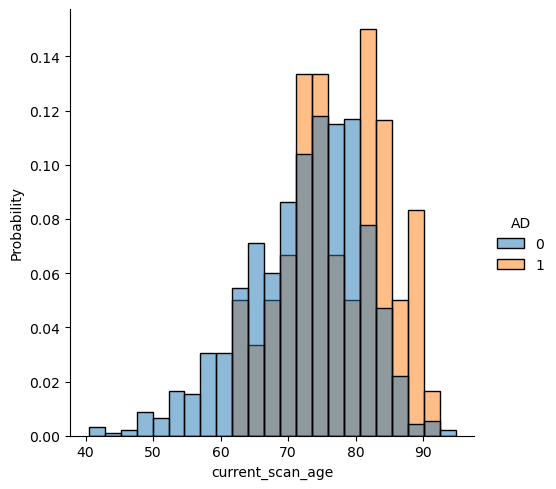

In [34]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

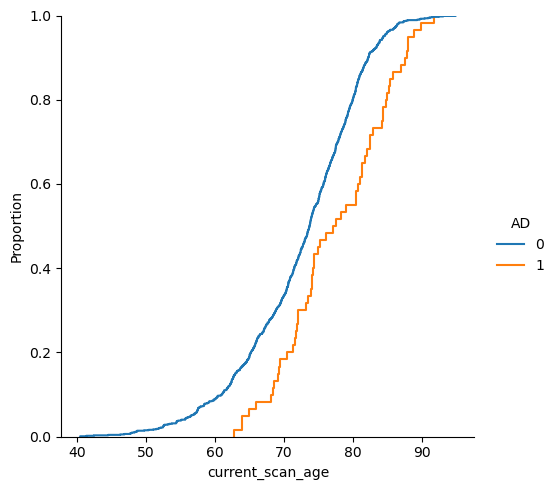

In [35]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

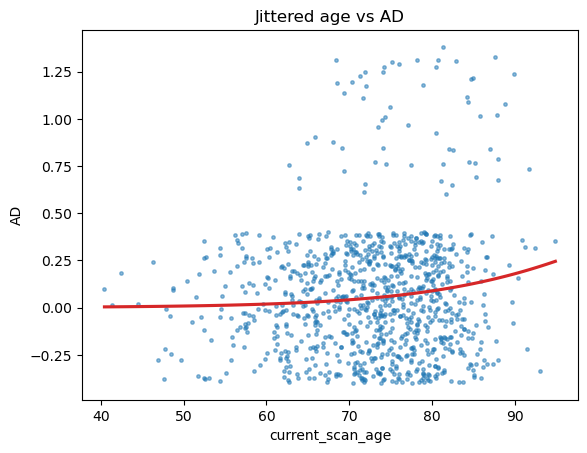

In [36]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

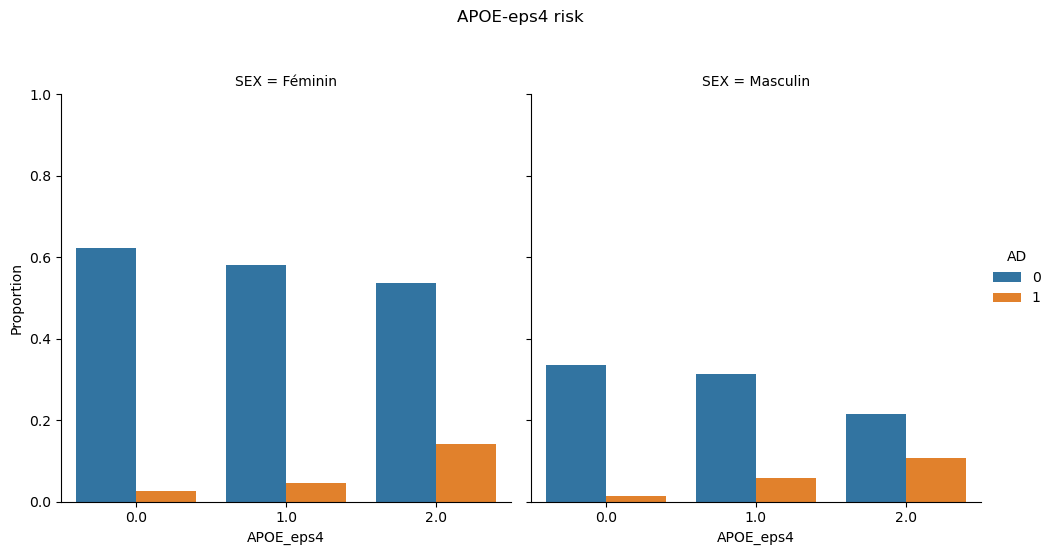

In [37]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

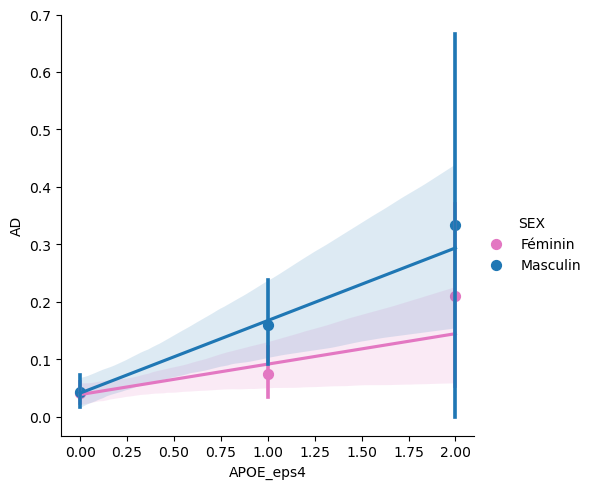

In [38]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [39]:
tst_edge_name = edges[0]
lhs, rhs = model_matrix(f"`{tst_edge_name}` ~ AD", df.dropna(subset="NIVETUD"))

In [40]:
model = sm.OLS(endog=lhs, exog=rhs)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     b'7Networks_LH_Vis_2'_b'7Networks_LH_Vis_1'   R-squared:                       0.004
Model:                                                     OLS   Adj. R-squared:                  0.002
Method:                                          Least Squares   F-statistic:                     3.427
Date:                                         Thu, 29 Feb 2024   Prob (F-statistic):             0.0644
Time:                                                 15:08:14   Log-Likelihood:                 112.63
No. Observations:                                          973   AIC:                            -221.3
Df Residuals:                                              971   BIC:                            -211.5
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5019      0.007     70.293      0.000       0.488       0.516
AD             0.0532      0.029      1.851      0.064      -0.003       0.110
==============================================================================
Omnibus:                        3.565   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                4.073
Skew:                          -0.008   Prob(JB):                        0.130
Kurtosis:                       3.317   Cond. No.                         4.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# TODO Return more fitting info
# TODO CEN_ANOM as random effect?
def fit_edges(ROI_name, dataframe):
    lhs, rhs = model_matrix(f"`{ROI_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD", dataframe)
    model = sm.OLS(endog=lhs, exog=rhs)
    result = model.fit()
    return result.params.AD, result.pvalues.AD
    

In [42]:
test_df = df.dropna(subset=["NIVETUD"])
fit_df = lambda edge: fit_edges(edge, test_df)

In [43]:
# Previous runtime 
parallel = Parallel(n_jobs=8, verbose=2)
test_results = parallel(delayed(fit_df)(edge) for edge in edges)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   27.8s
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:   42.6s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 4885 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 5816 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 6829 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 7922 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 9097 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 10352 tasks      | elapsed:  7.1min
[Parallel(n_

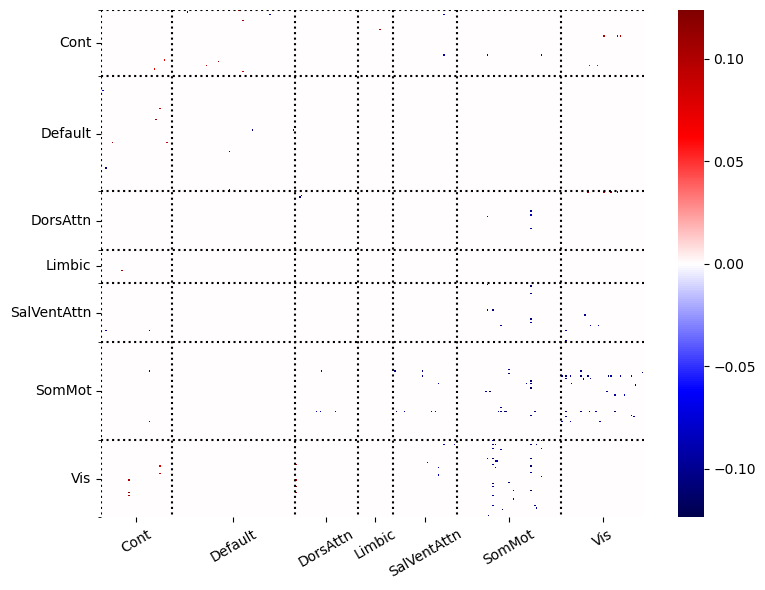

In [44]:
from bold_dementia.connectivity import plot_matrix
stats = [tr[0] for tr in test_results]
pvalues = [tr[1] for tr in test_results]
_, pvalues_corr = fdrcorrection(pvalues)

statmat = reshape_pvalues(stats)

pmat = reshape_pvalues(pvalues_corr)
display_mat = np.where(pmat < config["alpha"], statmat, 0)

plot_matrix(display_mat, atlas=atlas)
plt.show()

In [48]:
joblib.dump(statmat, matrices_path / "glm_stat.joblib")
joblib.dump(pmat, matrices_path / "glm_pvalues.joblib")

['/homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer__strategy-high_pass-motion-wm_csf/glm_pvalues.joblib']

In [45]:
from nilearn import plotting
coords = atlas.get_coords()

view = plotting.view_connectome(display_mat, coords)
view.open_in_browser()

In [46]:
conn_AD = df[edges + ["AD"]]
m = conn_AD.melt(id_vars=['AD'], var_name="edge", value_name="sample_connectivity")
sns.histplot(m, x="sample_connectivity", hue="AD", stat="probability", common_norm=False)
plt.show()

KeyboardInterrupt: 

### Assumptions on residuals

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result)

#### Normality

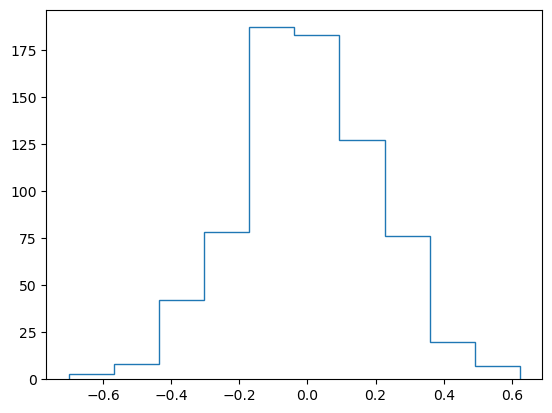

In [ ]:
plt.hist(result.resid, histtype="step")
plt.show()

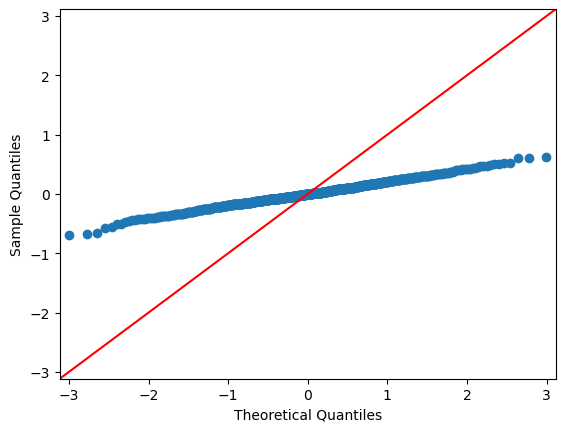

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(influence.resid, line="45")
plt.show()

#### Homoskedasticity

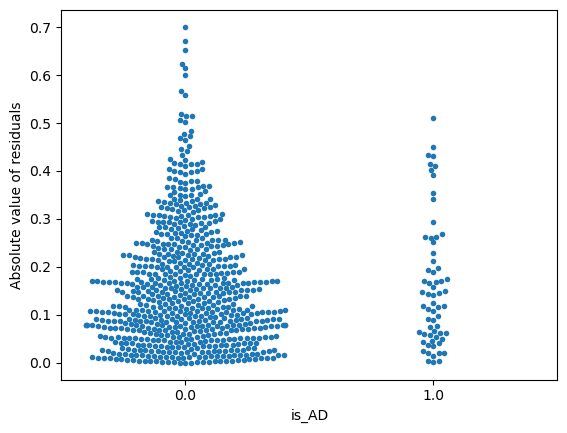

In [ ]:
# Spread Location plot
sns.swarmplot(
    x=model.exog[:, 1],
    y=abs(result.resid),
    size=4
)
plt.xlabel("is_AD")
plt.ylabel("Absolute value of residuals")
plt.show()

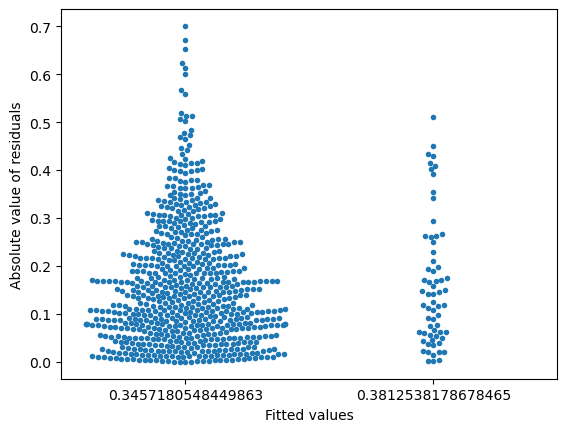

In [ ]:
sns.swarmplot(
    x=result.fittedvalues,
    y=abs(result.resid),
    size=4
)
plt.xlabel("Fitted values")
plt.ylabel("Absolute value of residuals")
plt.show()

#### Linearity

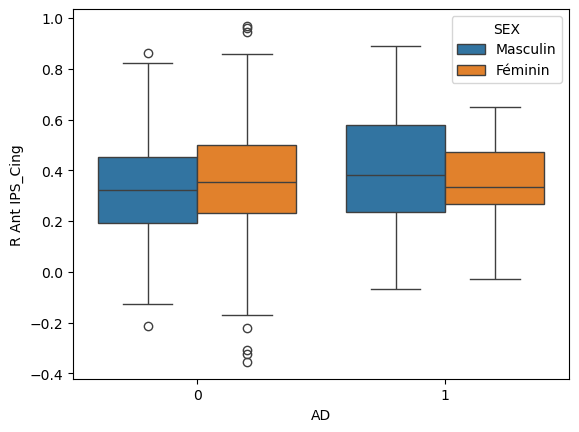

In [ ]:
# Linearity holds for categorical features
sns.boxplot(
    df,
    x="AD",
    y=tst_edge_name,
    hue="SEX"
)
plt.show()